# Generate Basic plots
## Start with default variables

In [97]:
# absolute path to raw results
raw_results_dir = "/home/mn.albeschenko/Yandex.Disk/Work/Projects/ceph/ceph_ostack_bench/results/rw"
raw_results_dir = "/home/admin013/yadisk/Work/Projects/ceph/ceph_ostack_bench/results/rw"
columns_for_df = [
  "iops_max",
  "iops_mean",
  "bw_max",
  "bw_mean",
  "lat_ns.max",
  "lat_ns.mean"
]
fig_size1x2 = (16, 5)

In [135]:
import os, json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as tkr
from pprint import pp

In [99]:
def fmt_bytes_per_sec(x, pos):
    if x<0:
        return ""
    for x_unit in ['B/s', 'kB/s', 'MB/s', 'GB/s', 'TB/s']:
        if x < 1024.0:
            return "%3.1f %s" % (x, x_unit)
        x /= 1024.0

def fmt_time(x, pos):
    if x<0:
        return ""
    for x_unit in ['ns', 'µs', 'ms', 's']:
        if x<1000.0:
            return "%3.1f %s" % (x, x_unit)
        x /= 1000.0


In [100]:
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))

In [101]:
# load all files in results dir into []{}
json_files = [os.path.join(raw_results_dir, pos_json) for pos_json in os.listdir(raw_results_dir)]
json_stats_read = []
json_stats_write = []


for index, js in enumerate(json_files):
  with open(js) as json_file:

    json_val = json.load(json_file)
    json_stat = json_val.get("client_stats")[0]
    json_stats_read.append(json_stat.get("read"))
    json_stats_write.append(json_stat.get("write"))

#clean unused variables
del json_val
del json_stat
del json_file
del json_files
del index
del js

In [102]:
df_read = pd.DataFrame(pd.json_normalize(json_stats_read), columns=columns_for_df)
df_write = pd.DataFrame(pd.json_normalize(json_stats_write), columns=columns_for_df)

del json_stats_read
del json_stats_write

In [103]:
# move bandwitch to Bytes per sec
# see https://fio.readthedocs.io/en/latest/fio_doc.html#json-output
df_read.bw_mean *= 1024
df_read.bw_max *= 1024
df_write.bw_max *= 1024
df_write.bw_mean *= 1024
# move lat from ns to ms
# df_read['lat_ns.max'] /= 1000000
# df_read['lat_ns.mean'] /= 1000000
# df_write['lat_ns.max'] /= 1000000
# df_write['lat_ns.mean'] /= 1000000
df_read.rename(columns={'lat_ns.max': 'lat_max', 'lat_ns.mean': 'lat_mean'}, inplace=True)
df_write.rename(columns={'lat_ns.max': 'lat_max', 'lat_ns.mean': 'lat_mean'}, inplace=True)

In [104]:
## this is example for one plot


# fig, ax = plt.subplots()
# ax.set_xlabel("VMs")
# ax.set_ylabel("IOPS")
# ax.set_title("IOPS: mean for all VMs")
# width = 0.4
# ax.bar(x=df_read.index, width=width, height=df_read["iops_mean"],
#         label = 'Read iops', color = 'royalblue')
# ax.bar(x=df_write.index+width, width=width, height=df_write["iops_mean"],
#         label = 'Write iops', color = 'gold')

# ax.axhline(y=np.nanmean(df_read[["iops_mean"]]), linestyle='--',
#             linewidth=2, label='Avg read iops', color = "blue")
# ax.axhline(y=np.nanmean(df_write[["iops_mean"]]), linestyle='--',
#             linewidth=2, label='Avg write iops', color = "orange")
# plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
#           fancybox=True, shadow=True, ncol=5)
# ax.xaxis.set_major_locator(tkr.MultipleLocator(1))
# ax.xaxis.set_major_formatter(tkr.FormatStrFormatter('%d'))
# plt.show()

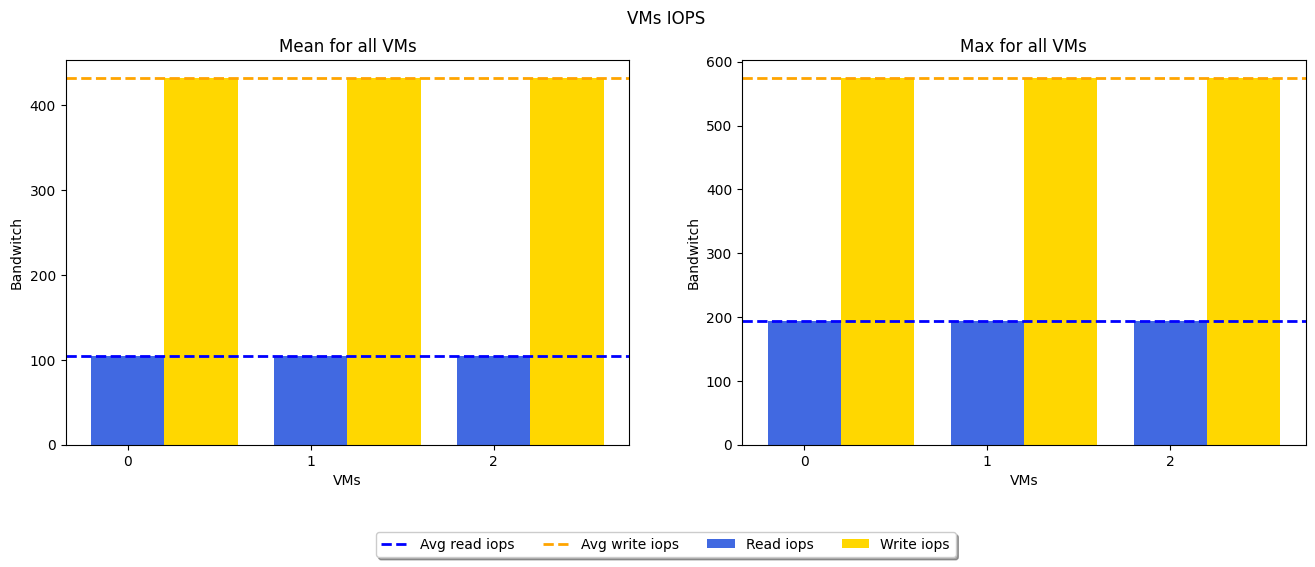

In [105]:
fig, ax = plt.subplots(1, 2, figsize=fig_size1x2)

fig.suptitle('VMs IOPS')

# common settings for plots
width = 0.4
for fax in ax:
  fax.set_xlabel("VMs")
  fax.set_ylabel("Bandwitch")
  fax.xaxis.set_major_locator(tkr.MultipleLocator(1))
  fax.xaxis.set_major_formatter(tkr.FormatStrFormatter('%d'))


ax[0].set_title("Mean for all VMs")
ax[0].bar(x=df_read.index, width=width, height=df_read["iops_mean"],
                label = 'Read iops', color = 'royalblue')
ax[0].bar(x=df_write.index+width, width=width, height=df_write["iops_mean"],
                label = 'Write iops', color = 'gold')

ax[0].axhline(y=np.nanmean(df_read[["iops_mean"]]), linestyle='--',
                linewidth=2, label='Avg read iops', color = "blue")
ax[0].axhline(y=np.nanmean(df_write[["iops_mean"]]), linestyle='--',
                linewidth=2, label='Avg write iops', color = "orange")



ax[1].set_title("Max for all VMs")
ax[1].bar(x=df_read.index, width=width, height=df_read["iops_max"],
                label = 'Read iops', color = 'royalblue')
ax[1].bar(x=df_write.index+width, width=width, height=df_write["iops_max"],
                label = 'Write iops', color = 'gold')

ax[1].axhline(y=np.nanmean(df_read[["iops_max"]]), linestyle='--',
                linewidth=2, label='Avg read iops', color = "blue")
ax[1].axhline(y=np.nanmean(df_write[["iops_max"]]), linestyle='--',
                linewidth=2, label='Avg write iops', color = "orange")

# do uniq labels
handles, labels = fig.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(handles=by_label.values(), labels=by_label.keys(), loc='upper center',
                bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)

plt.show()

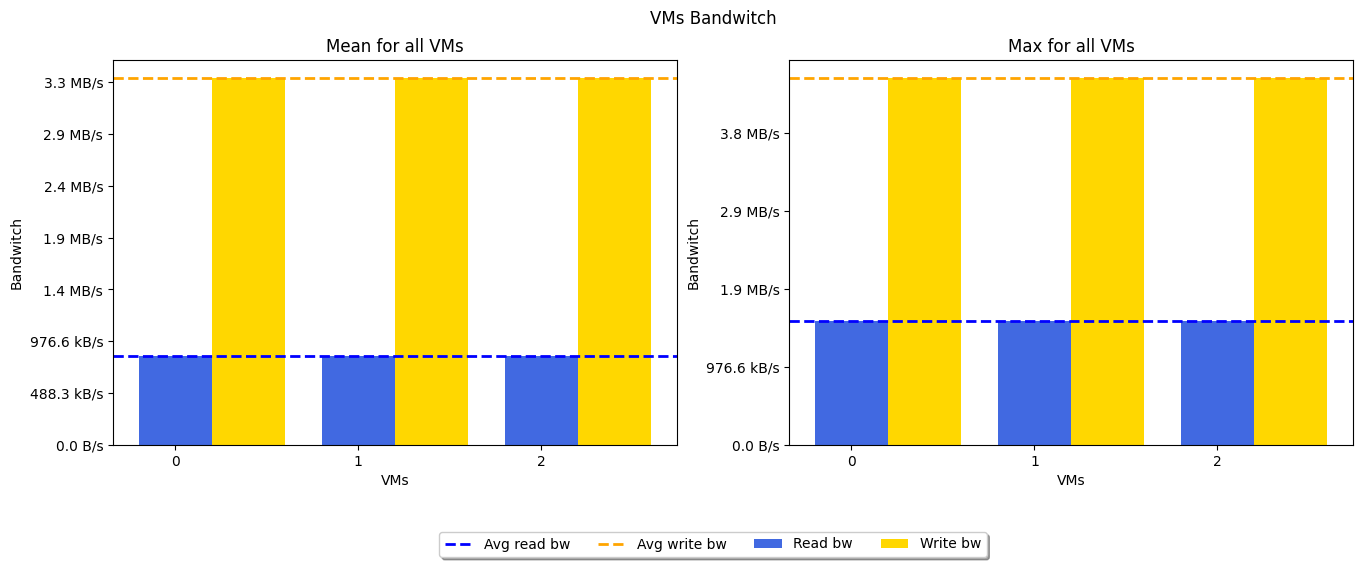

In [106]:
fig, ax = plt.subplots(1, 2, figsize=fig_size1x2)

fig.suptitle('VMs Bandwitch')

# common settings for plots
width = 0.4
for fax in ax:
  fax.set_xlabel("VMs")
  fax.set_ylabel("Bandwitch")
  fax.yaxis.set_major_formatter(tkr.FuncFormatter(fmt_bytes_per_sec))
  fax.xaxis.set_major_locator(tkr.MultipleLocator(1))
  fax.xaxis.set_major_formatter(tkr.FormatStrFormatter('%d'))


ax[0].set_title("Mean for all VMs")
ax[0].bar(x=df_read.index, width=width, height=df_read["bw_mean"],
                label = 'Read bw', color = 'royalblue')
ax[0].bar(x=df_write.index+width, width=width, height=df_write["bw_mean"],
                label = 'Write bw', color = 'gold')

ax[0].axhline(y=np.nanmean(df_read[["bw_mean"]]), linestyle='--',
                linewidth=2, label='Avg read bw', color = "blue")
ax[0].axhline(y=np.nanmean(df_write[["bw_mean"]]), linestyle='--',
                linewidth=2, label='Avg write bw', color = "orange")



ax[1].set_title("Max for all VMs")
ax[1].bar(x=df_read.index, width=width, height=df_read["bw_max"],
                label = 'Read bw', color = 'royalblue')
ax[1].bar(x=df_write.index+width, width=width, height=df_write["bw_max"],
                label = 'Write bw', color = 'gold')

ax[1].axhline(y=np.nanmean(df_read[["bw_max"]]), linestyle='--',
                linewidth=2, label='Avg read bw', color = "blue")
ax[1].axhline(y=np.nanmean(df_write[["bw_max"]]), linestyle='--',
                linewidth=2, label='Avg write bw', color = "orange")

# do uniq labels
handles, labels = fig.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(handles=by_label.values(), labels=by_label.keys(), loc='upper center',
                bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)

plt.show()

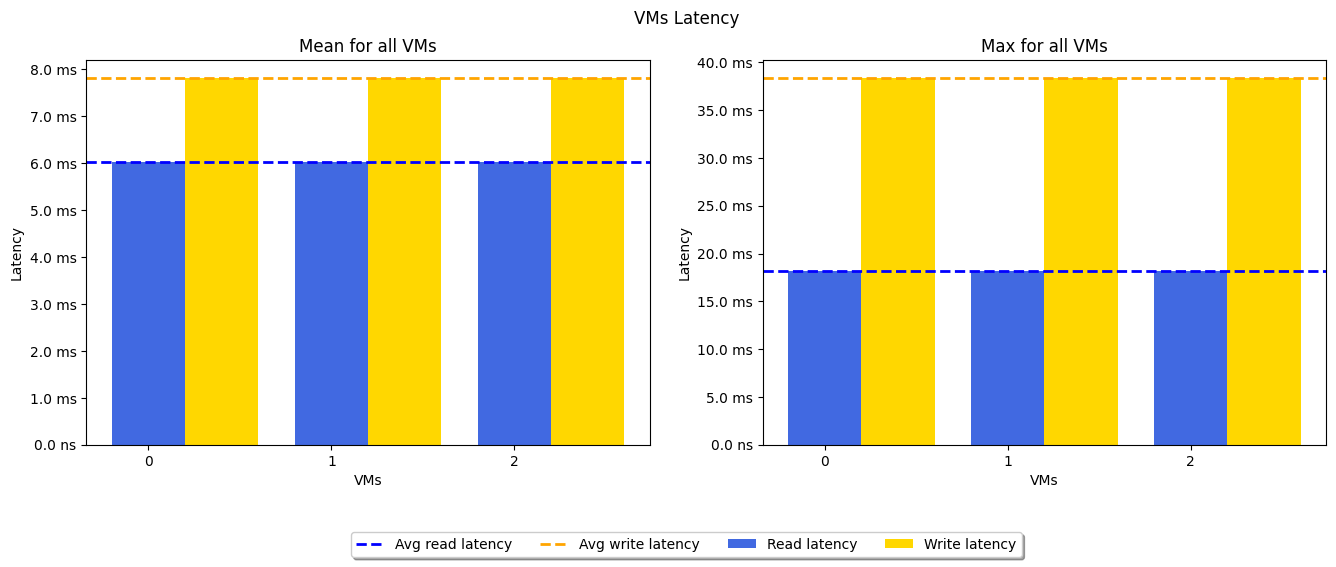

In [107]:
fig, ax = plt.subplots(1, 2, figsize=fig_size1x2)

fig.suptitle('VMs Latency')

# common settings for plots
width = 0.4
for fax in ax:
  fax.set_xlabel("VMs")
  fax.set_ylabel("Latency")
  fax.yaxis.set_major_formatter(tkr.FuncFormatter(fmt_time))
  fax.xaxis.set_major_locator(tkr.MultipleLocator(1))
  fax.xaxis.set_major_formatter(tkr.FormatStrFormatter('%d'))


ax[0].set_title("Mean for all VMs")
ax[0].bar(x=df_read.index, width=width, height=df_read["lat_mean"],
                label = 'Read latency', color = 'royalblue')
ax[0].bar(x=df_write.index+width, width=width, height=df_write["lat_mean"],
                label = 'Write latency', color = 'gold')

ax[0].axhline(y=np.nanmean(df_read[["lat_mean"]]), linestyle='--',
                linewidth=2, label='Avg read latency', color = "blue")
ax[0].axhline(y=np.nanmean(df_write[["lat_mean"]]), linestyle='--',
                linewidth=2, label='Avg write latency', color = "orange")



ax[1].set_title("Max for all VMs")
ax[1].bar(x=df_read.index, width=width, height=df_read["lat_max"],
                label = 'Read latency', color = 'royalblue')
ax[1].bar(x=df_write.index+width, width=width, height=df_write["lat_max"],
                label = 'Write latency', color = 'gold')

ax[1].axhline(y=np.nanmean(df_read[["lat_max"]]), linestyle='--',
                linewidth=2, label='Avg read latency', color = "blue")
ax[1].axhline(y=np.nanmean(df_write[["lat_max"]]), linestyle='--',
                linewidth=2, label='Avg write latency', color = "orange")

# do uniq labels
handles, labels = fig.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(handles=by_label.values(), labels=by_label.keys(), loc='upper center',
                bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)

plt.show()

In [145]:
result = {
  'read': {
    'iops_max_sum': round(df_read['iops_max'].sum()),
    'iops_mean_sum': round(df_read['iops_mean'].sum()),
    'bw_max_sum': fmt_bytes_per_sec(df_read['bw_max'].sum(), 0),
    'bw_mean_sum': fmt_bytes_per_sec(df_read['bw_mean'].sum(), 0),
    'lat_max_avg': fmt_time(df_read['lat_max'].mean(), 0),
    'lat_mean_avg': fmt_time(df_read['lat_mean'].mean(), 0),
  },
  'write': {
    'iops_max_sum': round(df_write['iops_max'].sum()),
    'iops_mean_sum': round(df_write['iops_mean'].sum()),
    'bw_max_sum': fmt_bytes_per_sec(df_write['bw_max'].sum(), 0),
    'bw_mean_sum': fmt_bytes_per_sec(df_write['bw_mean'].sum(), 0),
    'lat_max_avg': fmt_time(df_write['lat_max'].mean(), 0),
    'lat_mean_avg': fmt_time(df_write['lat_mean'].mean(), 0),
  }
}

pp(result)


{'read': {'iops_max_sum': 582,
          'iops_mean_sum': 314,
          'bw_max_sum': '4.5 MB/s',
          'bw_mean_sum': '2.5 MB/s',
          'lat_max_avg': '18.2 ms',
          'lat_mean_avg': '6.0 ms'},
 'write': {'iops_max_sum': 1722,
           'iops_mean_sum': 1296,
           'bw_max_sum': '13.5 MB/s',
           'bw_mean_sum': '10.1 MB/s',
           'lat_max_avg': '38.3 ms',
           'lat_mean_avg': '7.8 ms'}}
